In [1]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee

In [4]:
file=open( '../../../data/raw_data/20160428_1313_W1204_ref.pkl' , 'rb')
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

I took a week off and worked on this. It was suggested that since the previous MCMC generated a Tau that was not expected, as well as corner plots that were stretched, that I make sure that the code was correct. 
To do so I set the 'Data' to a model with assigned values, and ran the code to see if it would generate the original assigned values. 

This is shown below.

Mira


In [5]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

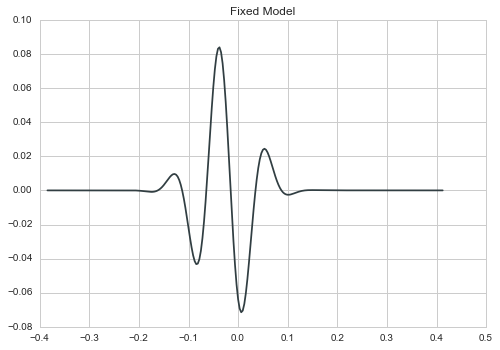

In [7]:
t,D = psi1(-.03, 10, .05, .049) #expected values, z q p T
D = D*.0006 #a
pl.plot(t,D)
pl.title('Fixed Model')

The assigned values are: z = -.03, q = 10, p = .05, Tau = .049, a = .0006. 
Tau2, the AC coupling constant, is set to .559 for both the Fixed Model and the Model. 

In [8]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-Modelf*a),D-Modelf*a))
    Sig=0.0005  
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [9]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [-.03, 10, .05, .049, .0006], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]
#print result ["x"]

In [10]:
#prior function
#again, why is it ln?
def lnprior(params):
    znot, q, p, T, a = params 
    if -.08 < znot < .08 and 1.0 < q < 15.0 and .01 < p < .1 and 0.0 < T < .06 and 0.0 < a < .001:
        return 0.0
    return -np.inf 
    

In [11]:
#log probability function
def lnprob (params, t, D):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, t, D)

In [12]:
ndim, nwalkers = 5,260
pos = [result["x"] + 10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]

In [13]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(t,D))

In [14]:
sampler.run_mcmc(pos, 5000); #number of steps

(260, 5000, 5)


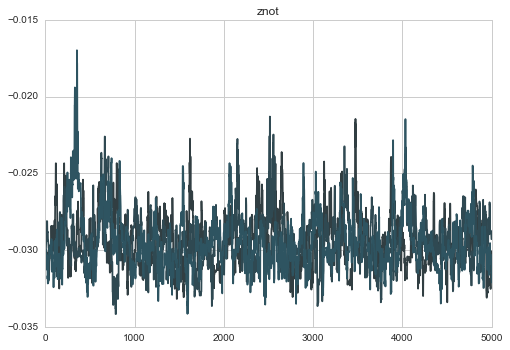

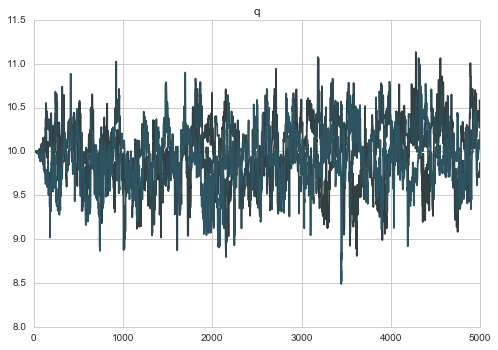

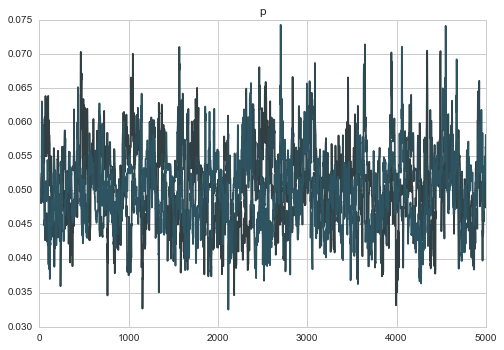

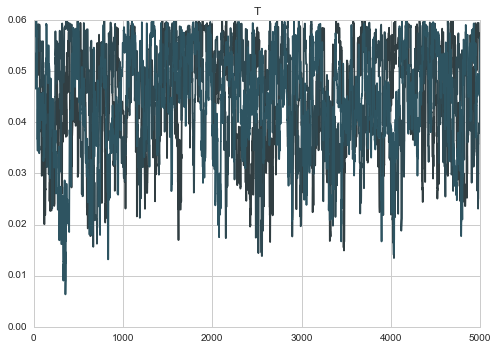

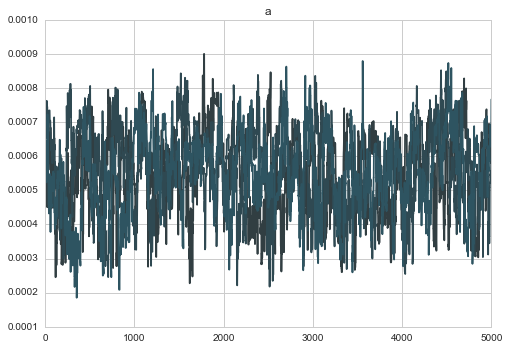

In [15]:
walks=(sampler.chain)
print(np.shape(walks))

for nn in range(0,ndim):
    pl.plot(walks[0,:,nn])
    pl.plot(walks[1,:,nn])
    pl.plot(walks[2,:,nn])
    titles = ['znot','q','p','T','a']
    pl.title(titles[nn])
    pl.show() #sigma = .001

The plots below show the progress of one of the arbitrarily chosen walkers for each parameter. From these it can be decided where/when the walkers settle into their final locations.

In [16]:
samples = sampler.chain[:,2500:,:].reshape([-1, ndim])
#print(np.shape(samples))

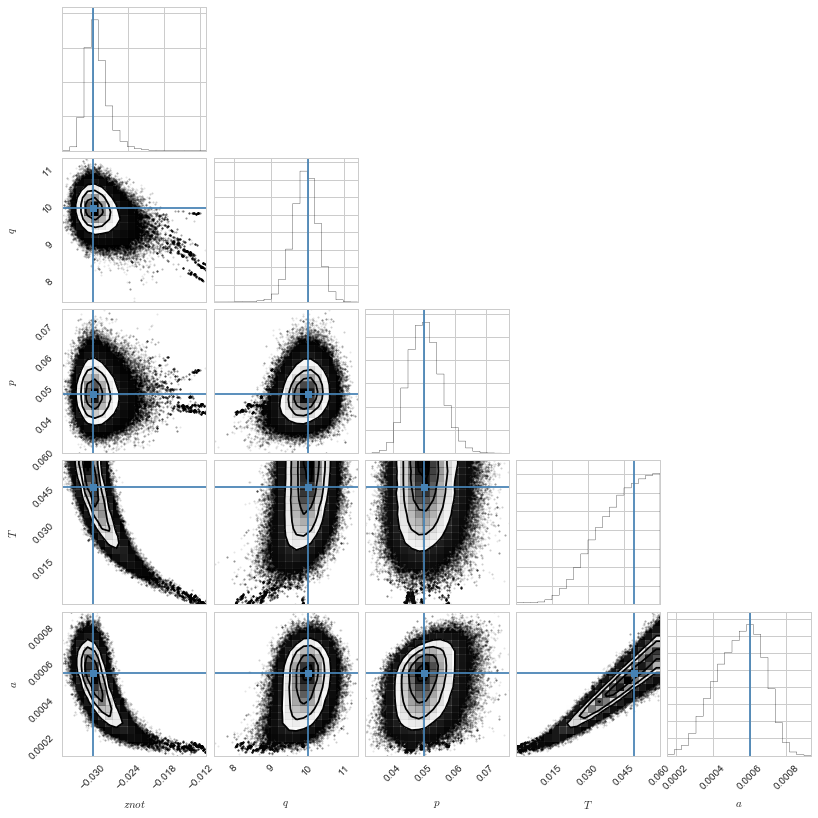

In [17]:
import corner
fig = corner.corner(samples, labels=["$znot$", "$q$", "$p$", "$T$", "$a$"], 
                    truths=[-.03, 10, .05, .049, .0006])
fig.savefig("MCMCattempt2.png")

Using this information, corner plots and histograms are made representing the original guessed values, the plots, and the probabilities.

From this it is clear that the suggested values are closed to the assigned values, and that therefore the code works. 

It is interesting to note though that there seems to be a correlation between Tau and a as well as Tau and z, suggesting that perhaps the stretching/smearing in the MCMC with the actual data is also due to some correlation. 